## Dollar-Euro exchange rate in past 2 years

In this example, I will use web scrapping technique to explain and visualize the monthly fluctuations in the exchange rate between the US Dollar (USD) and the Euro (EUR) over the span of the past two years. After that, I will give an example of connection with Amazon Web Services (AWS) and store the new dataframe in AWS bucket.

I will be using Alpha Vantage API from https://www.alphavantage.co/. It's stored in my local computer's enviromental variables.

In [2]:
import pandas as pd ###using pandas in order to structure data in a dataframe and get all other benefits while wrangling data
import os ###using os for enviromental variables 
import requests ###using requests to get the data from the website
import matplotlib.pyplot as plt ###using matplot.lib.pyplot to plot data and show trends - to visually depict my goal
import boto3 ###using boto3 to connect with and store data into my aws account

In [3]:
api = os.environ.get('alphavantageapi')
url = 'https://www.alphavantage.co/query?function=FX_MONTHLY&from_symbol=EUR&to_symbol=USD&apikey=api'
r = requests.get(url)
data = r.json()
#print(data)

In [16]:
dataframe = pd.DataFrame.from_dict(data['Time Series FX (Monthly)'], orient = 'index')
dataframe.columns = ['Open', 'High', 'Low', 'Close']
dataframe
###Columns are represented as following:
#Open - the moment when the stock market is open
#Close - the moment when the stock market is closed 
#High - the moment when the USD had the smallest value for a particular day 
#Low - the moment when the USD had the biggest value for a particular day
###Monthly data from 2004 to 2023. It needs to be wrangled and cleaned to extract the desired information. I will append a column
###with all dates transformed to a date type of data. After that it's gonna be easier to interpret the information.

,Open,High,Low,Close
2023-08-23,1.09966,1.10652,1.08010,1.08634
2023-07-31,1.09076,1.12758,1.08330,1.09968
2023-06-30,1.06856,1.10122,1.06610,1.09074
2023-05-31,1.10178,1.10917,1.06340,1.06856
2023-04-28,1.08418,1.10954,1.07870,1.10140
...,...,...,...,...
2004-11-30,1.27400,1.33340,1.26520,1.32810
2004-10-29,1.24310,1.28410,1.22230,1.27830
2004-09-30,1.21850,1.24440,1.20220,1.24310
2004-08-31,1.20620,1.23880,1.19650,1.21740


In [5]:
import datetime as dt

transposeddf = pd.DataFrame.transpose(dataframe)


YearMonthDay = []
for month in transposeddf:
    YearMonthDay.append(dt.datetime.strptime(month, "%Y-%m-%d").date())
###using datetime to get date type of data
###Transposing dataframe to iterate through the columns and get all dates
#print(YearMonthDay)    

In [6]:
dataframe['Month'] = YearMonthDay
###appending a new list to a dataframe
#print(dataframe)

In [7]:
finaldataframe = pd.DataFrame(dataframe.iloc[0:26])
print(finaldataframe)
###Since I am interested only in the last two years, I created a new dataframe with data for the last two years

               Open     High      Low    Close       Month
2023-08-23  1.09966  1.10652  1.08010  1.08634  2023-08-23
2023-07-31  1.09076  1.12758  1.08330  1.09968  2023-07-31
2023-06-30  1.06856  1.10122  1.06610  1.09074  2023-06-30
2023-05-31  1.10178  1.10917  1.06340  1.06856  2023-05-31
2023-04-28  1.08418  1.10954  1.07870  1.10140  2023-04-28
2023-03-31  1.05743  1.09300  1.05150  1.08381  2023-03-31
2023-02-28  1.08610  1.10327  1.05310  1.05748  2023-02-28
2023-01-31  1.07031  1.09294  1.04816  1.08626  2023-01-31
2022-12-30  1.04041  1.07363  1.03906  1.07025  2022-12-30
2022-11-30  0.98818  1.04969  0.97280  1.04041  2022-11-30
2022-10-31  0.97954  1.00937  0.96290  0.98814  2022-10-31
2022-09-30  1.00507  1.01979  0.95320  0.98003  2022-09-30
2022-08-31  1.02182  1.03687  0.98990  1.00501  2022-08-31
2022-07-29  1.04770  1.04820  0.99500  1.02248  2022-07-29
2022-06-30  1.07308  1.07738  1.03570  1.04771  2022-06-30
2022-05-31  1.05464  1.07870  1.03480  1.07313  2022-05-

In [10]:
minimumvaluesofUSD = finaldataframe['Open'].sort_values(ascending = False)
maximumvaluesofUSD = finaldataframe['Open'].sort_values(ascending = True)
strongestUSD = maximumvaluesofUSD[0:1]
weakestUSD = minimumvaluesofUSD[0:1]
print(strongestUSD) ###2022-10-31: 0.97954
print(weakestUSD) ###2021-08-31    1.18635

2022-10-31    0.97954
Name: Open, dtype: object
2021-08-31    1.18635
Name: Open, dtype: object


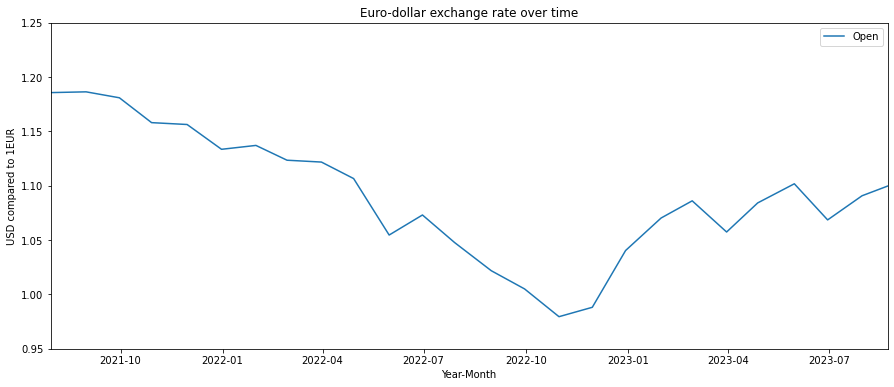

In [13]:
finaldataframe[['Open', 'High', 'Low', 'Close']] = finaldataframe[['Open', 'High', 'Low', 'Close']].astype(float)
###Changing data type because before changing it to numeric format in order to plot the trend


finaldataframe.plot(x="Month", y='Open', kind="line") ###x axis will be column Month and y axis will be column Open
plt.ylim(0.95, 1.25)
plt.xlim(finaldataframe['Month']['2021-07-30'], finaldataframe['Month']['2023-08-23'])

plt.xlabel('Year-Month')
plt.ylabel('USD compared to 1EURO')
plt.title('Euro-dollar exchange rate over time')
plt.rcParams["figure.figsize"] = (15,8)
plt.show()

From the visualization above, we can easily see how value of EURO dropped during 2022. In November and December the value of EURO was even weaker than value of USD. In 2023 the value of EURO started strengthening again. 

## Initializing s3 connection

In [17]:
#aws_access_key_id = os.environ['aws_access_key_id']
#aws_secret_access_key = os.environ['aws_secret_access_key']
#s3 = boto3.client('s3', region_name='us-east-1',  
#                        aws_access_key_id=aws_access_key_id, 
#                         aws_secret_access_key=aws_secret_access_key)

In [18]:
#bucket = 'your-bucket-name'

#s3.upload_file(
#    Filename = 'exchangerateEURUSD.csv',
#    Bucket = bucket,
#    Key = 'exchangerateEURUSD.csv'
#)
###Uploading file to s3

In [19]:
#s3.put_object_acl(
#    Bucket = bucket,
#    Key = 'exchangerateEURUSD.csv',
#    ACL = 'public-read'
#)

###Allowing public access to url

## Creating a URL to share data

In [20]:
#url = "https://{}.s3.amazonaws.com/{}".format(bucket, "exchangerateEURUSD.csv")
#url
###'https://your-bucket-name.s3.amazonaws.com/exchangerateEURUSD.csv'

Danilo Nikcevic